In [1]:
# In[1]: Imports and device setup
import os
import torch
import numpy as np
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize, Normalize

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# In[2]: Dataset with RGB‑to‑class remapping
class MarsSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None,
                 image_suffix="img_", mask_suffix="mask_"):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # list images and masks
        self.image_files = sorted([f for f in os.listdir(image_dir)
                                   if f.startswith(image_suffix) and f.endswith(".png")])
        self.mask_files = sorted([f for f in os.listdir(mask_dir)
                                  if f.startswith(mask_suffix) and f.endswith(".png")])
        assert len(self.image_files)==len(self.mask_files), "Image/mask count mismatch"

        # expected RGB → class index
        self.rgb_to_class = {
            (0, 0, 0): 0,         # background
            (255, 255, 0): 1,     # Crater (yellow)
            (255, 0, 0): 2,       # Rough (red)
            (0, 255, 0): 3,       # Smooth (green)
            (0, 0, 255): 4        # Alluvial_Fan (blue)
        }

    def remap_mask(self, mask: Image.Image) -> np.ndarray:
        mask_arr = np.array(mask.convert("RGB"))
        h, w, _ = mask_arr.shape
        remapped = np.zeros((h, w), dtype=np.uint8)
        for rgb, cls in self.rgb_to_class.items():
            matches = np.all(mask_arr==rgb, axis=-1)
            remapped[matches] = cls
        return remapped

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.image_files[idx])).convert("RGB")
        msk = Image.open(os.path.join(self.mask_dir, self.mask_files[idx]))
        msk = self.remap_mask(msk)

        if self.transform:
            aug = self.transform(image=np.array(img), mask=msk)
            img, msk = aug['image'], aug['mask']
        return img, msk.long()

In [15]:
# In[3]: Transforms and DataLoaders
transform = Compose([
    Resize(256,256, interpolation=0),
    Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

def get_loaders(img_dir, mask_dir, transform, batch_size=16):
    ds = MarsSegmentationDataset(img_dir, mask_dir, transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

train_loader = get_loaders(r"D:\u net\new base\train_images",
                           r"D:\u net\new base\train_masks",
                           transform, batch_size=16)
val_loader   = get_loaders(r"D:\u net\new base\val_image",
                           r"D:\u net\new base\val_mask",
                           transform, batch_size=8)


In [16]:
# In[4]: UNet model definition
class encoding_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, out_channels=5, features=[64,128,256,512]):
        super().__init__()
        self.pool = nn.MaxPool2d(2,2)
        # encoder
        self.enc1 = encoding_block(3, features[0])
        self.enc2 = encoding_block(features[0], features[1])
        self.enc3 = encoding_block(features[1], features[2])
        self.enc4 = encoding_block(features[2], features[3])
        self.bottleneck = encoding_block(features[3], features[3]*2)
        # decoder
        self.up1 = nn.ConvTranspose2d(features[3]*2, features[3], 2,2)
        self.dec1 = encoding_block(features[3]*2, features[3])
        self.up2 = nn.ConvTranspose2d(features[3], features[2], 2,2)
        self.dec2 = encoding_block(features[2]*2, features[2])
        self.up3 = nn.ConvTranspose2d(features[2], features[1], 2,2)
        self.dec3 = encoding_block(features[1]*2, features[1])
        self.up4 = nn.ConvTranspose2d(features[1], features[0], 2,2)
        self.dec4 = encoding_block(features[0]*2, features[0])
        self.final = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(self.pool(s1))
        s3 = self.enc3(self.pool(s2))
        s4 = self.enc4(self.pool(s3))
        b  = self.bottleneck(self.pool(s4))
        d1 = self.dec1(torch.cat([self.up1(b), s4], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d1), s3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), s2], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d3), s1], dim=1))
        return self.final(d4)

model = UNet(out_channels=5).to(DEVICE)


In [17]:
# In[5]: Training loop with customizable number of epochs
num_epochs = 100  # <-- Set this to any number you want

optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch [{epoch}/{num_epochs}]")
    running_loss = 0.0
    for imgs, masks in loop:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg = running_loss / len(train_loader)
    print(f"Epoch {epoch} average loss: {avg:.4f}")

Epoch [1/100]: 100%|██████████████████████████████████████████████████████| 250/250 [07:16<00:00,  1.75s/it, loss=0.91]


Epoch 1 average loss: 1.1432


Epoch [2/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:11<00:00,  1.73s/it, loss=0.967]


Epoch 2 average loss: 0.9317


Epoch [3/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.779]


Epoch 3 average loss: 0.8261


Epoch [4/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.691]


Epoch 4 average loss: 0.7656


Epoch [5/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.578]


Epoch 5 average loss: 0.6984


Epoch [6/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.611]


Epoch 6 average loss: 0.6657


Epoch [7/100]: 100%|██████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.59]


Epoch 7 average loss: 0.6157


Epoch [8/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.504]


Epoch 8 average loss: 0.5648


Epoch [9/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:10<00:00,  1.72s/it, loss=0.499]


Epoch 9 average loss: 0.5318


Epoch [10/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.616]


Epoch 10 average loss: 0.4897


Epoch [11/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.389]


Epoch 11 average loss: 0.4600


Epoch [12/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.314]


Epoch 12 average loss: 0.4431


Epoch [13/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.826]


Epoch 13 average loss: 0.4217


Epoch [14/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.405]


Epoch 14 average loss: 0.3922


Epoch [15/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.355]


Epoch 15 average loss: 0.3988


Epoch [16/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.329]


Epoch 16 average loss: 0.3611


Epoch [17/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.404]


Epoch 17 average loss: 0.3375


Epoch [18/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.315]


Epoch 18 average loss: 0.3432


Epoch [19/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.311]


Epoch 19 average loss: 0.3274


Epoch [20/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.345]


Epoch 20 average loss: 0.3114


Epoch [21/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.371]


Epoch 21 average loss: 0.2941


Epoch [22/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.236]


Epoch 22 average loss: 0.3021


Epoch [23/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.343]


Epoch 23 average loss: 0.2761


Epoch [24/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.255]


Epoch 24 average loss: 0.2523


Epoch [25/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.245]


Epoch 25 average loss: 0.2566


Epoch [26/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.29]


Epoch 26 average loss: 0.2551


Epoch [27/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.274]


Epoch 27 average loss: 0.2565


Epoch [28/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.219]


Epoch 28 average loss: 0.2430


Epoch [29/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.165]


Epoch 29 average loss: 0.2409


Epoch [30/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.148]


Epoch 30 average loss: 0.2185


Epoch [31/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.213]


Epoch 31 average loss: 0.2397


Epoch [32/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.187]


Epoch 32 average loss: 0.2035


Epoch [33/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.22]


Epoch 33 average loss: 0.2082


Epoch [34/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.23]


Epoch 34 average loss: 0.2327


Epoch [35/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.203]


Epoch 35 average loss: 0.2264


Epoch [36/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.174]


Epoch 36 average loss: 0.1708


Epoch [37/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.202]


Epoch 37 average loss: 0.1625


Epoch [38/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:07<00:00,  1.71s/it, loss=0.186]


Epoch 38 average loss: 0.1589


Epoch [39/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:07<00:00,  1.71s/it, loss=0.187]


Epoch 39 average loss: 0.1755


Epoch [40/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.197]


Epoch 40 average loss: 0.1779


Epoch [41/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:07<00:00,  1.71s/it, loss=0.235]


Epoch 41 average loss: 0.1595


Epoch [42/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:07<00:00,  1.71s/it, loss=0.269]


Epoch 42 average loss: 0.1510


Epoch [43/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.178]


Epoch 43 average loss: 0.1744


Epoch [44/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.119]


Epoch 44 average loss: 0.1395


Epoch [45/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.157]


Epoch 45 average loss: 0.1358


Epoch [46/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.295]


Epoch 46 average loss: 0.1907


Epoch [47/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0894]


Epoch 47 average loss: 0.1648


Epoch [48/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.121]


Epoch 48 average loss: 0.1266


Epoch [49/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.149]


Epoch 49 average loss: 0.1245


Epoch [50/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0974]


Epoch 50 average loss: 0.1942


Epoch [51/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:10<00:00,  1.72s/it, loss=0.12]


Epoch 51 average loss: 0.1242


Epoch [52/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:30<00:00,  1.80s/it, loss=0.146]


Epoch 52 average loss: 0.1259


Epoch [53/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.112]


Epoch 53 average loss: 0.1801


Epoch [54/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0979]


Epoch 54 average loss: 0.1238


Epoch [55/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0911]


Epoch 55 average loss: 0.1130


Epoch [56/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.127]


Epoch 56 average loss: 0.1078


Epoch [57/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.149]


Epoch 57 average loss: 0.1214


Epoch [58/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.118]


Epoch 58 average loss: 0.1350


Epoch [59/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.282]


Epoch 59 average loss: 0.1378


Epoch [60/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.132]


Epoch 60 average loss: 0.1468


Epoch [61/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.109]


Epoch 61 average loss: 0.1052


Epoch [62/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.31]


Epoch 62 average loss: 0.1292


Epoch [63/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.103]


Epoch 63 average loss: 0.1587


Epoch [64/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0953]


Epoch 64 average loss: 0.1109


Epoch [65/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0859]


Epoch 65 average loss: 0.0982


Epoch [66/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0723]


Epoch 66 average loss: 0.0961


Epoch [67/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.151]


Epoch 67 average loss: 0.1171


Epoch [68/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0977]


Epoch 68 average loss: 0.1094


Epoch [69/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0854]


Epoch 69 average loss: 0.0924


Epoch [70/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0866]


Epoch 70 average loss: 0.0908


Epoch [71/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.122]


Epoch 71 average loss: 0.0901


Epoch [72/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.129]


Epoch 72 average loss: 0.1539


Epoch [73/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0909]


Epoch 73 average loss: 0.1015


Epoch [74/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0934]


Epoch 74 average loss: 0.1047


Epoch [75/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0883]


Epoch 75 average loss: 0.0879


Epoch [76/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0744]


Epoch 76 average loss: 0.0834


Epoch [77/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0641]


Epoch 77 average loss: 0.0835


Epoch [78/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0931]


Epoch 78 average loss: 0.1141


Epoch [79/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.123]


Epoch 79 average loss: 0.0918


Epoch [80/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0675]


Epoch 80 average loss: 0.0851


Epoch [81/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0792]


Epoch 81 average loss: 0.0806


Epoch [82/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0555]


Epoch 82 average loss: 0.0800


Epoch [83/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.135]


Epoch 83 average loss: 0.0947


Epoch [84/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.148]


Epoch 84 average loss: 0.1222


Epoch [85/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0756]


Epoch 85 average loss: 0.0837


Epoch [86/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0716]


Epoch 86 average loss: 0.0784


Epoch [87/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0762]


Epoch 87 average loss: 0.0799


Epoch [88/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.073]


Epoch 88 average loss: 0.0747


Epoch [89/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0714]


Epoch 89 average loss: 0.0745


Epoch [90/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.161]


Epoch 90 average loss: 0.1338


Epoch [91/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0862]


Epoch 91 average loss: 0.1044


Epoch [92/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0594]


Epoch 92 average loss: 0.0757


Epoch [93/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.123]


Epoch 93 average loss: 0.0811


Epoch [94/100]: 100%|████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.112]


Epoch 94 average loss: 0.0784


Epoch [95/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:09<00:00,  1.72s/it, loss=0.0829]


Epoch 95 average loss: 0.0866


Epoch [96/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0704]


Epoch 96 average loss: 0.0704


Epoch [97/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.0686]


Epoch 97 average loss: 0.0684


Epoch [98/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.0983]


Epoch 98 average loss: 0.0696


Epoch [99/100]: 100%|█████████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.72s/it, loss=0.09]


Epoch 99 average loss: 0.0691


Epoch [100/100]: 100%|███████████████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it, loss=0.097]

Epoch 100 average loss: 0.1103


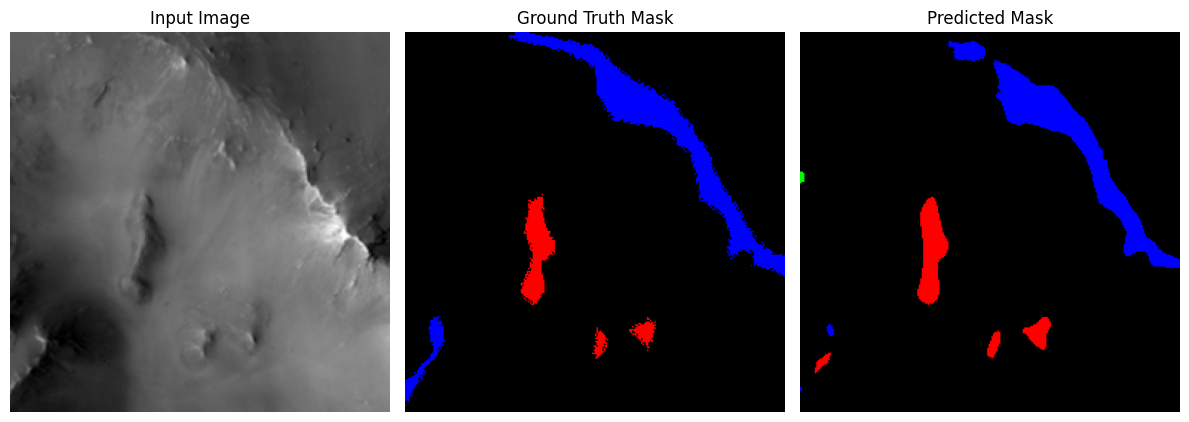

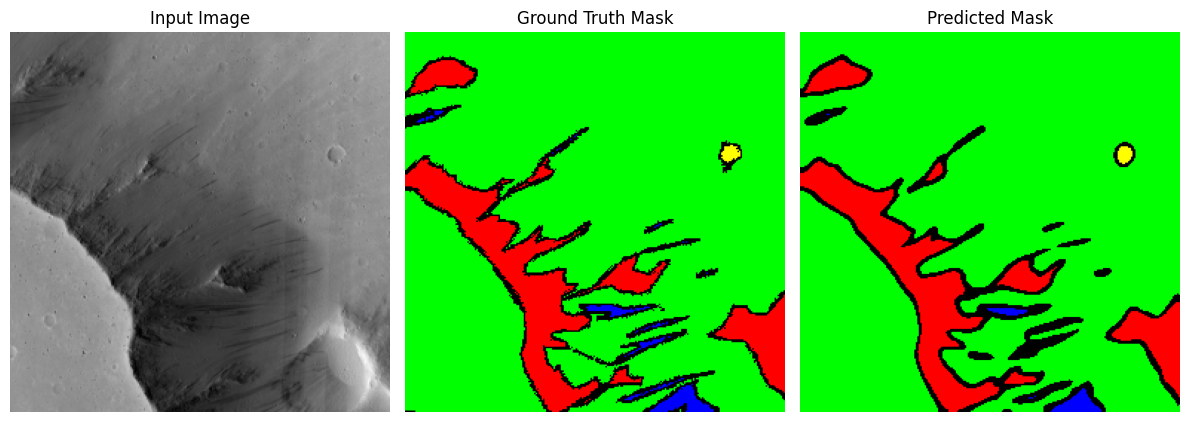

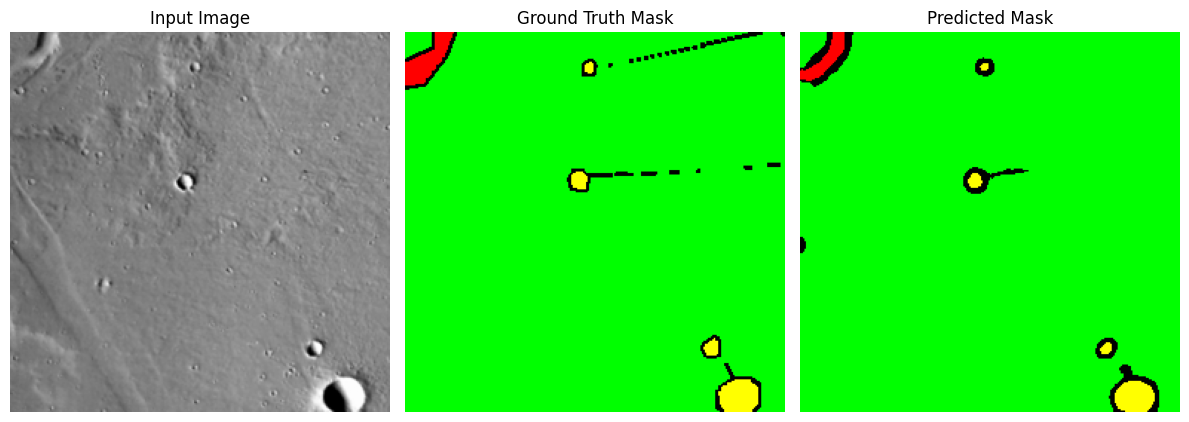

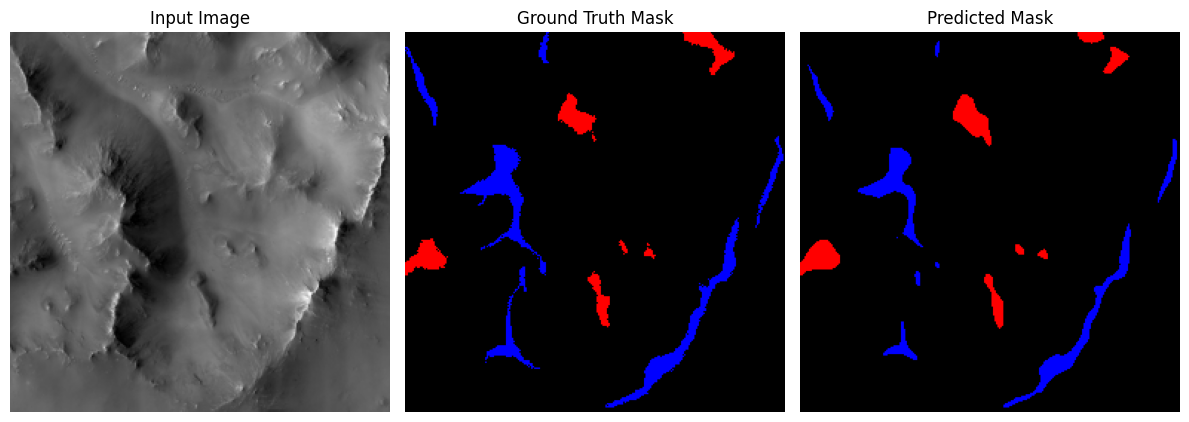

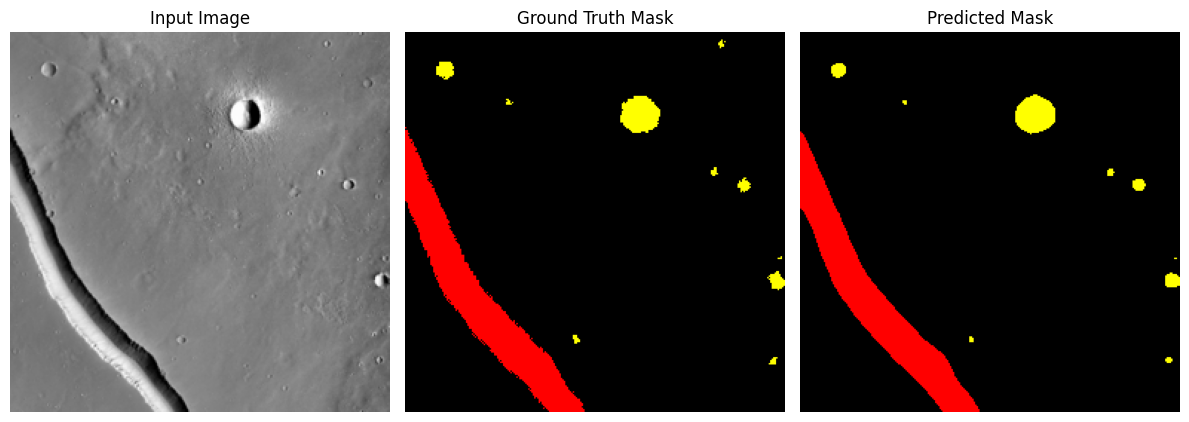

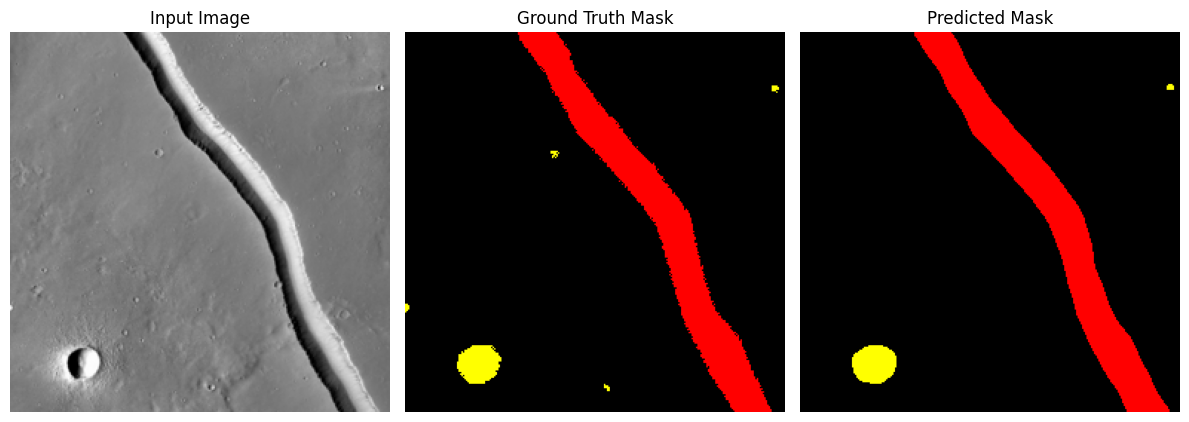

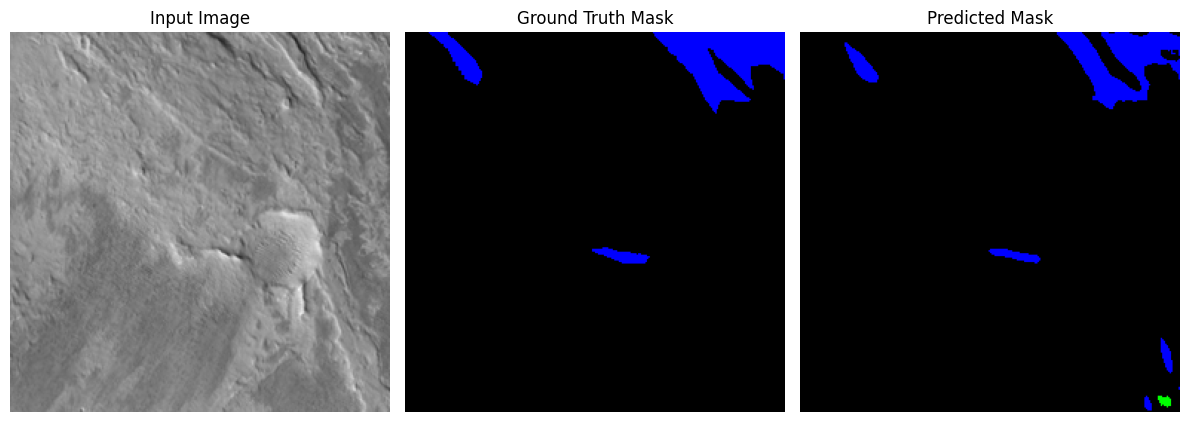

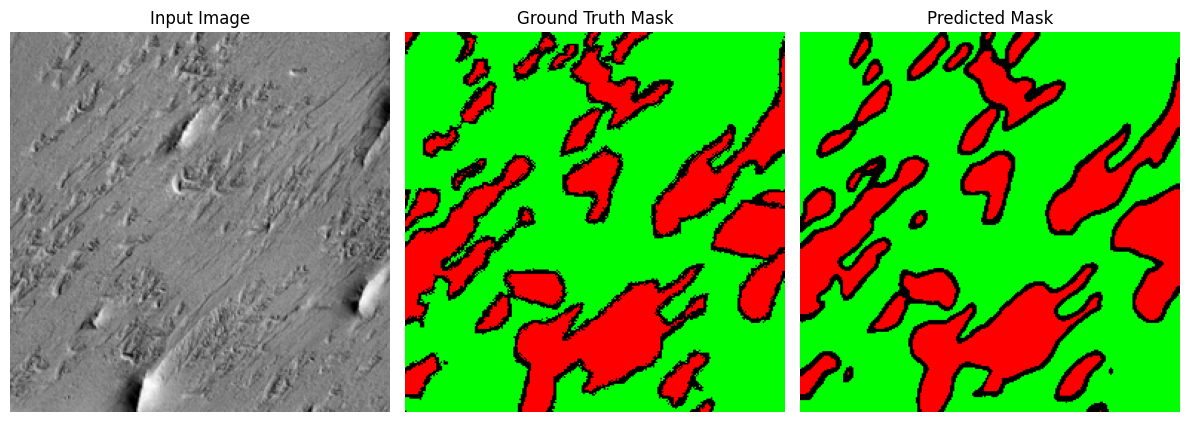

IndexError: index 8 is out of bounds for axis 0 with size 8

In [22]:
# In[7]: Visualize color‐coded predictions vs. ground truth

import matplotlib.pyplot as plt
import numpy as np
import torch

# Define class→RGB colormap
colormap = {
    0: (0, 0, 0),       # background
    1: (255, 255, 0),   # Crater (yellow)
    2: (255, 0, 0),     # Rough (red)
    3: (0, 255, 0),     # Smooth (green)
    4: (0, 0, 255)      # Alluvial_Fan (blue)
}

def decode_mask(mask, colormap):
    """
    Convert 2D class mask to RGB image using colormap.
    mask: H×W array of class indices
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in colormap.items():
        rgb[mask == cls] = color
    return rgb

# Grab a batch from validation loader
model.eval()
imgs, true_masks = next(iter(val_loader))

# Predict
with torch.no_grad():
    logits = model(imgs.to(DEVICE))
    pred_masks = torch.argmax(logits, dim=1).cpu().numpy()

# Prepare images for display: unnormalize
imgs_np = imgs.permute(0, 2, 3, 1).cpu().numpy()  # B×H×W×C
imgs_np = (imgs_np * 0.5) + 0.5                   # back to [0,1]

# Visualize first N samples
N = 30
for i in range(N):
    img = imgs_np[i]
    gt = true_masks[i].numpy()
    pred = pred_masks[i]
    
    gt_color = decode_mask(gt, colormap)
    pred_color = decode_mask(pred, colormap)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    axes[1].imshow(gt_color)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    
    axes[2].imshow(pred_color)
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()



In [23]:
# In[7]: Evaluation metrics computation

import time
import numpy as np
import torch
import torch.nn.functional as F

# --- 1. Metric definitions --- #
def compute_confusion_elements(pred, true, class_id):
    """
    Compute TP, FP, FN for one class.
    """
    pred_i = (pred == class_id)
    true_i = (true == class_id)
    tp = np.logical_and(pred_i, true_i).sum()
    fp = np.logical_and(pred_i, ~true_i).sum()
    fn = np.logical_and(~pred_i, true_i).sum()
    return tp, fp, fn

def compute_iou(tp, fp, fn):
    """IoU = TP / (TP + FP + FN)"""  # :contentReference[oaicite:0]{index=0}
    return tp / (tp + fp + fn) if (tp + fp + fn)>0 else 0.0

def compute_dice(tp, fp, fn):
    """Dice = 2·TP / (2·TP + FP + FN)"""  # :contentReference[oaicite:1]{index=1}
    return 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn)>0 else 0.0

def compute_precision(tp, fp):
    """Precision = TP / (TP + FP)"""  # :contentReference[oaicite:2]{index=2}
    return tp / (tp + fp) if (tp + fp)>0 else 0.0

def compute_recall(tp, fn):
    """Recall = TP / (TP + FN)"""  # :contentReference[oaicite:3]{index=3}
    return tp / (tp + fn) if (tp + fn)>0 else 0.0

# --- 2. Evaluation loop --- #
def evaluate_model(model, dataloader, criterion, num_classes=5, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_time = 0.0
    count = 0

    # accumulators per class
    sum_tp = np.zeros(num_classes, dtype=np.int64)
    sum_fp = np.zeros(num_classes, dtype=np.int64)
    sum_fn = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # inference time measurement best practices :contentReference[oaicite:4]{index=4}
            torch.cuda.synchronize() if device!='cpu' else None
            t0 = time.time()
            logits = model(imgs)
            torch.cuda.synchronize() if device!='cpu' else None
            t1 = time.time()

            total_time += (t1 - t0) * imgs.size(0)
            count += imgs.size(0)

            # loss
            loss = criterion(logits, masks)
            total_loss += loss.item() * imgs.size(0)

            # predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            trues = masks.cpu().numpy()

            # accumulate TP, FP, FN per class
            for c in range(num_classes):
                for p, t in zip(preds, trues):
                    tp, fp, fn = compute_confusion_elements(p, t, c)
                    sum_tp[c] += tp
                    sum_fp[c] += fp
                    sum_fn[c] += fn

    # compute per‑class and mean metrics
    ious, dices, precisions, recalls = [], [], [], []
    for c in range(num_classes):
        iou = compute_iou(sum_tp[c], sum_fp[c], sum_fn[c])
        dice = compute_dice(sum_tp[c], sum_fp[c], sum_fn[c])
        prec = compute_precision(sum_tp[c], sum_fp[c])
        rec = compute_recall(sum_tp[c], sum_fn[c])
        ious.append(iou); dices.append(dice); precisions.append(prec); recalls.append(rec)

    # aggregate
    metrics = {
        'IoU_per_class': ious, 
        'Mean_IoU': np.mean(ious),
        'Dice_per_class': dices,
        'Mean_Dice': np.mean(dices),
        'Precision_per_class': precisions,
        'Mean_Precision': np.mean(precisions),
        'Recall_per_class': recalls,
        'Mean_Recall': np.mean(recalls),
        'Avg_Loss': total_loss / count,       # :contentReference[oaicite:5]{index=5}
        'Avg_Inference_Time': total_time / count
    }
    return metrics

# --- 3. Run evaluation --- #
metrics = evaluate_model(model, val_loader, criterion, num_classes=5, device=DEVICE)

# --- 4. Display results --- #
for k, v in metrics.items():
    print(f"{k}: {v}")


IoU_per_class: [0.865401720024789, 0.8820243017082025, 0.8689205838003451, 0.9373748073783543, 0.7502352913454368]
Mean_IoU: 0.8607913408514255
Dice_per_class: [0.9278448826704082, 0.9373144660328148, 0.9298635708034676, 0.9676752312546121, 0.8572964961399192]
Mean_Dice: 0.9239989293802445
Precision_per_class: [0.9207400419673982, 0.9507611403426072, 0.9378794516271219, 0.9646295004759488, 0.9181694770631191]
Mean_Precision: 0.9384359222952391
Recall_per_class: [0.9350602242852598, 0.9242428416806061, 0.9219835492935758, 0.9707402561941555, 0.8039931967484022]
Mean_Recall: 0.9112040136403998
Avg_Loss: 0.1591609815955162
Avg_Inference_Time: 0.09135391426086426


In [28]:
# Inference on a single test image
from PIL import Image
import cv2

def predict_and_visualize(image_path, model, transform, colormap):
    """
    Predicts the segmentation mask for a single image and visualizes it.
    """
    model.eval()
    
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    augmented = transform(image=img_np)
    input_tensor = augmented['image'].unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Decode predicted mask to color image
    pred_color = decode_mask(pred_mask, colormap)

    # Prepare original image for display (unnormalize)
    img_disp = (augmented['image'].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5
    img_disp = np.clip(img_disp, 0, 1)

    # Show
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].imshow(img_disp)
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    
    axes[1].imshow(pred_color)
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()


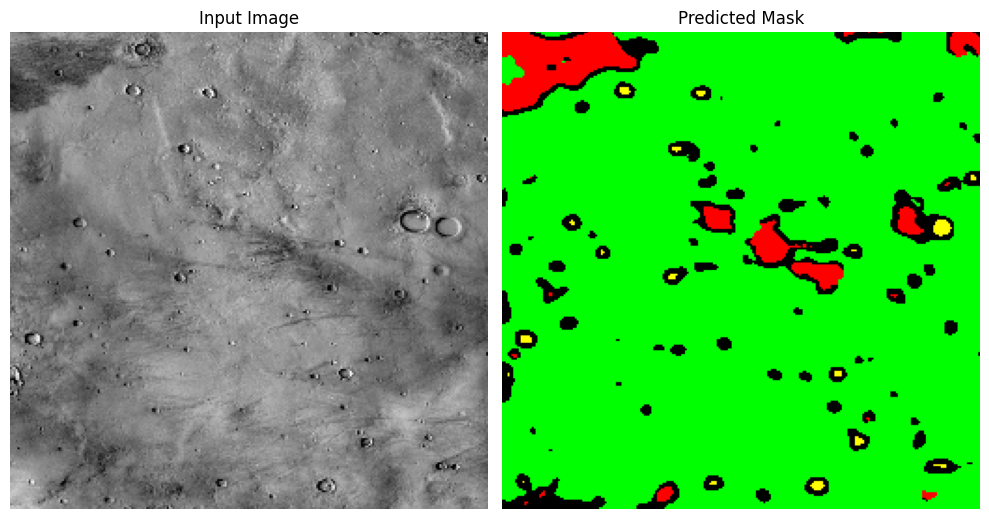

In [56]:
test_image_path = r"C:\Users\HP\Downloads\a2.png"
predict_and_visualize(test_image_path, model, transform, colormap)
